In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('/Users/saikarthik/Desktop/xai /nasdq.csv', index_col=0, parse_dates=True)



In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])



In [11]:
def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])  # Sequence of past 60 days
        y.append(data[i, 0])  # Next day's price
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data)


In [12]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  

model.compile(optimizer='adam', loss='mean_squared_error')


2024-11-12 20:57:17.810053: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-12 20:57:17.810090: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-12 20:57:17.810097: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-12 20:57:17.810524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-12 20:57:17.810912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Step 7: Make predictions
predicted_prices = model.predict(x_test)

# Step 8: Inverse transform the predictions and the true values to original scale
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/10


2024-11-12 20:57:29.488694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 20:57:29.726126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 20:57:29.801355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 20:57:29.959228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 20:57:30.098299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


97/97 [==============================] - 4s 23ms/step - loss: 0.0050
Epoch 2/10
97/97 [==============================] - 2s 18ms/step - loss: 1.1820e-04
Epoch 3/10
97/97 [==============================] - 2s 17ms/step - loss: 1.2562e-04
Epoch 4/10
97/97 [==============================] - 2s 18ms/step - loss: 1.1322e-04
Epoch 5/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1568e-04
Epoch 6/10
97/97 [==============================] - 2s 18ms/step - loss: 1.1339e-04
Epoch 7/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1084e-04
Epoch 8/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1003e-04
Epoch 9/10
97/97 [==============================] - 2s 18ms/step - loss: 1.0994e-04
Epoch 10/10
97/97 [==============================] - 2s 17ms/step - loss: 1.0236e-04


2024-11-12 20:57:48.587103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 20:57:48.653710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-12 20:57:48.701014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 9ms/step


In [15]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_rescaled, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_test_rescaled, predicted_prices)
print(f"R-Squared (R²): {r2}")

mse = mean_squared_error(y_test_rescaled, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 1.4328367127175472
R-Squared (R²): 0.9232474201579317
Mean Squared Error (MSE): 3.3625501913071525


Root Mean Squared Error: 1.8337257677491343


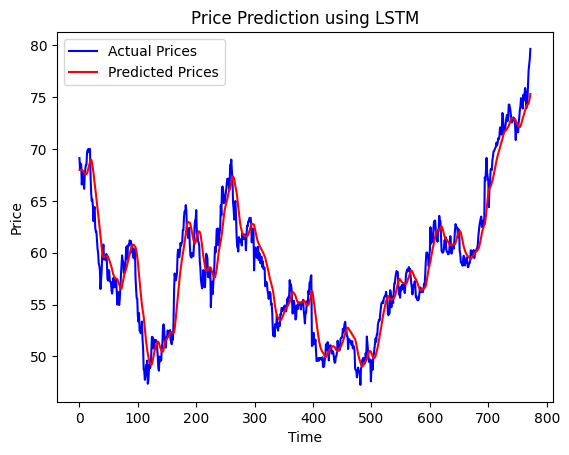

In [16]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_prices))
print(f"Root Mean Squared Error: {rmse}")

# Step 10: Plot the predictions vs. actual values
plt.plot(y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
model.save('lstm_model.h5')  


/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
last_sequence = scaled_data[-60:]  
last_sequence = last_sequence.reshape(1, 60, 1) 

next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)  # Rescale to original price

print(f"Next day's predicted price: {next_day_prediction[0][0]}")


1/1 [==============================] - 0s 44ms/step
Next day's predicted price: 75.7529296875


In [ ]:
# Predicting the next week's prices (5 days)
predictions_week = []
current_sequence = scaled_data[-60:]  

for _ in range(5): 
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_week.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  # Shift the sequence for next prediction

print("Predicted prices for next week:", predictions_week)


1/1 [==============================] - 0s 15ms/step
Predicted prices for next week: [75.75293, 75.979095, 76.09307, 76.13587, 76.13305]


In [28]:
print(np.mean(predictions_week))

76.01881


In [ ]:
# Predicting the next month's prices (20 days)
predictions_month = []
current_sequence = scaled_data[-60:]  

for _ in range(20):  
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_month.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  # Shift the sequence for next prediction

print("Predicted prices for next month:", predictions_month)


1/1 [==============================] - 0s 15ms/step
Predicted prices for next month: [75.75293, 75.979095, 76.09307, 76.13587, 76.13305, 76.10132, 76.05164, 75.99107, 75.92419, 75.8539, 75.78199, 75.709595, 75.6374, 75.56578, 75.494965, 75.425064, 75.356125, 75.28813, 75.2211, 75.15501]


In [29]:
np.mean((predictions_month))

75.73256

In [ ]:
predictions_year = []
current_sequence = scaled_data[-60:]  

for _ in range(252): 
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_year.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  

print("Predicted prices for next year:", predictions_year)


1/1 [==============================] - 0s 14ms/step
Predicted prices for next year: [75.75293, 75.979095, 76.09307, 76.13587, 76.13305, 76.10132, 76.05164, 75.99107, 75.92419, 75.8539, 75.78199, 75.709595, 75.6374, 75.56578, 75.494965, 75.425064, 75.356125, 75.28813, 75.2211, 75.15501, 75.089806, 75.02548, 74.962006, 74.89936, 74.83752, 74.77645, 74.71616, 74.65659, 74.59776, 74.53966, 74.48222, 74.42549, 74.36942, 74.31401, 74.259254, 74.205124, 74.15162, 74.09874, 74.04645, 73.99477, 73.943665, 73.89316, 73.8432, 73.7938, 73.744965, 73.69667, 73.64891, 73.60168, 73.55498, 73.50877, 73.46309, 73.41791, 73.37321, 73.328995, 73.28528, 73.24203, 73.199234, 73.15691, 73.115036, 73.073616, 73.03263, 72.992096, 72.95198, 72.91229, 72.873024, 72.834175, 72.79574, 72.75769, 72.720055, 72.6828, 72.64595, 72.60947, 72.57337, 72.53765, 72.502304, 72.46731, 72.43268, 72.3984, 72.36448, 72.3309, 72.29767, 72.26476, 72.23221, 72.19997, 72.16806, 72.136475, 72.1052, 72.07426, 72.04362, 72.013275, 71

In [30]:
np.mean((predictions_year))

71.67781